# Задача 1


In [1]:
import torch
import torch.nn as nn

import os, os.path
import time
from glob import glob

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import matplotlib.pyplot as plt

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [3]:
# задание выполнялось на google colab

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Подготовка данных

Для начала напишем класс для загрузки и распределения по классам исходных изображений. Во время работы этот класс опирается на исходную структуру директории с данными.

In [4]:
class ArtistsDataset(Dataset):
    def __init__(self, images_dir, transforms=None):
        self.images = []
        self.classes = []

        for class_num, dirname in enumerate(sorted(os.listdir(images_dir))):
            full_dirname = os.path.join(images_dir, dirname)
            for filename in sorted(os.listdir(full_dirname)):
                self.images.append(Image.open(os.path.join(full_dirname, filename)))
                self.classes.append(class_num)

        self.length = len(self.classes)
        self.transforms = transforms
        
    def __len__(self):
        return self.length
                   
    def __getitem__(self, idx):
        image = self.images[idx]
        class_num = self.classes[idx]

        if self.transforms is not None:
            for transform in self.transforms:
                image = transform(image)

        image = transforms.ToTensor()(image).unsqueeze_(0)[0]
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return (image, class_num)

Задание выполнялось на гуглколабе, поэтому я смог позволить себе обучение изображений размера $128 \times 128$. 

Кроме того, я решил добавить в датасет случайное горизонтальное отражение изображения, потому что подобное преобразование, очевидно, не меняет класс изображения и имеет смысл в контексте картины. Остальные аугментации показались мне излишними по перечисленным выше причинам.

Преобразование к тензору и последующая нормализация уже встроены в класс датасета.

In [5]:
DATA_PATH = '/content/drive/MyDrive/BostonGene/Задание 1/images/'

full_dataset = ArtistsDataset(DATA_PATH, transforms=[transforms.Resize((128,128)), transforms.RandomHorizontalFlip()])

После выгрузки датасета разделим его на обучение и контроль для обучения нашей нейронной сети.

In [6]:
test_size = int(len(full_dataset) * 0.3)
train_size = len(full_dataset) - test_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print('Train size: ', train_size)
print('Test size: ', test_size)

Train size:  996
Test size:  426


Загрузим обучающую и тестовую выборки в DataLoader'ы и поместим их в словарь для облегчения дальнейшего доступа.

In [7]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size=16, num_workers=2)

image_loaders = {'train':train_data_loader, 'val':test_data_loader}

## Настройка модели

Для решения задания мною была выбрана классическая архитектура **VGG13** с некоторыми изменениями.

Я модифицировал блок `classifier` так, чтобы сеть могла обрабатывать изображения проивольной формы (в нашем случае $128 \times 128$), а не только формата $224 \times 224$, как в оригинале. Разумеется, выход сети был адаптирован под количество классов (в нашей задаче их $8$).

Также я измненил предпоследнюю размерность признакового пространства в сети на $128$ (в оригинале $1024$) для решения дополнительного задания. Это несильно повлияло на качество сети, однако в дальнейшем поможет нам смягчить эффекты проклятия размерности во время кластреризации эмбедингов.

Остальные элементы сети не подверглись изменениям. Отмечу, что я использовал предобученный `feature_extractor` как основу алгоритма. Исходный датасет состоит из $1422$ изображений, чего недостаточно для обучения с нуля такой крупной сети как **VGG13**.

In [58]:
class VGG_modified(nn.Module):
    def __init__(self, num_classes, feature_output, pretrained=True):
        super().__init__()
        self.feature_extractor = vgg13(pretrained=pretrained).features
        self.classifier = nn.Sequential(
            nn.Linear(feature_output, 4096, bias=True),
            nn.ReLU(True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(4096, 128, bias=True),
            nn.ReLU(True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(128, num_classes, bias=True)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Рассматриваемые параметры обучения были подобранны эмпирическим путём. Размерность же входа `classifier`'а вычисляется отдельно для каждого датасета.

In [62]:
import torch.optim as optim
from torch.optim import lr_scheduler

num_epochs = 25
lr = 5 * 1e-6
weight_decay = 1e-1
step_size = 5
gamma = 0.001

input_test = vgg13()
output = input_test.features(next(iter(train_data_loader))[0])

feature_output = output.view(output.size(0), -1).shape[1]
num_classes = len(np.unique(full_dataset.classes))
model = VGG_modified(num_classes, feature_output)

my_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

cuda:0


## Обучение модели

Процесс обучения в целом весьма стандартный. В качестве лосса была выбрана кросс-энтропия, в качестве метрики точность. Функция обучения поддерживает логирование по эпохам: значения лосса и метрики на обучении и контроле для каждой эпохи как выводится на экран, так и записывается в список.

In [34]:
def train_model(model, dataloaders, criterion, num_epochs=10, device='cpu'):
    since = time.time()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    model = model.to(device)

    val_acc_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return val_loss_history, val_acc_history, time_elapsed

Функция, представленная ниже, выводит графики лосса и метрики по входным массивам.

In [35]:
def show_progress(loss, metric, loss_title, metric_title):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(15)

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(loss)), loss, 'r', linewidth=2)

    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('mean loss', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.title(loss_title, fontsize=14)
    
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(metric)), metric, 'b', linewidth=2)

    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('criterion', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.title(metric_title, fontsize=14)

    plt.grid()
    plt.show()

In [63]:
criterion = nn.CrossEntropyLoss()

loss, acc, total_time = train_model(model, image_loaders, criterion, num_epochs=num_epochs, device=my_device)

Epoch 0/24
----------
train Loss: 2.0551 Acc: 0.1757
val Loss: 1.9728 Acc: 0.3310

Epoch 1/24
----------
train Loss: 1.9035 Acc: 0.3253
val Loss: 1.8085 Acc: 0.3709

Epoch 2/24
----------
train Loss: 1.7065 Acc: 0.4167
val Loss: 1.5438 Acc: 0.4859

Epoch 3/24
----------
train Loss: 1.4237 Acc: 0.5281
val Loss: 1.2642 Acc: 0.6197

Epoch 4/24
----------
train Loss: 1.1718 Acc: 0.6235
val Loss: 1.0606 Acc: 0.6502

Epoch 5/24
----------
train Loss: 0.9793 Acc: 0.6717
val Loss: 0.9670 Acc: 0.6690

Epoch 6/24
----------
train Loss: 0.8965 Acc: 0.6878
val Loss: 0.9315 Acc: 0.7089

Epoch 7/24
----------
train Loss: 0.7622 Acc: 0.7560
val Loss: 0.8459 Acc: 0.7207

Epoch 8/24
----------
train Loss: 0.6711 Acc: 0.7902
val Loss: 0.8306 Acc: 0.7207

Epoch 9/24
----------
train Loss: 0.5904 Acc: 0.8363
val Loss: 0.8049 Acc: 0.7488

Epoch 10/24
----------
train Loss: 0.5681 Acc: 0.8163
val Loss: 0.7905 Acc: 0.7488

Epoch 11/24
----------
train Loss: 0.4927 Acc: 0.8464
val Loss: 0.8069 Acc: 0.7371

Ep

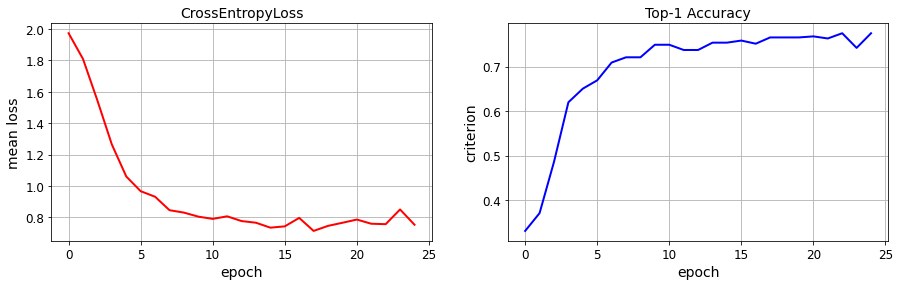

In [64]:
show_progress(loss, acc, 'CrossEntropyLoss', 'Top-1 Accuracy')

В целом, нейронная сеть показала весьма неплохой результат, достигнув точности $78\%$ на тестовой выборке. Гиперпараметры были подобраны так, чтобы обеспечить стабильность и устойчивость поведения алгоритма, чего, как мне кажется, удалось достичь.

# Дополнительная часть

## Формирование датасета

In [65]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

import seaborn as sns

import xgboost
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split

Воспользуемся механизмом хуков из библиотеки `pytorch` для того, чтобы получить выходы предпоследнего слоя обученной сети.

In [66]:
global encoding

def hook_fn(module, input, output):
    global encoding
    encoding = output

hook = model.classifier[-2].register_forward_hook(hook_fn)

Данная функция преобразует исходный датасет по батчам и агрегирует полученные тензоры в один `numpy` массив.

In [67]:
def get_encoding(model, dataloader, device):
    model.eval()
    batch_encoding = []
    classes = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)

        outputs = model(inputs)
        batch_encoding.append(encoding.cpu().detach())
        classes.append(labels)

    X = batch_encoding[0]
    y = classes[0]

    for labels, batch in zip(classes[1:], batch_encoding[1:]):
        X = torch.vstack((X, batch))
        y = torch.hstack((y, labels))

    return X.numpy(), y.numpy()

Воспользуемся уже имеющимся разбиением на обучающую и тестовую выборки для последующих экспериментов. Однако для следующего раздела нам понадобится объединённый (целый) датасет.

In [68]:
X_train, y_train = get_encoding(model, image_loaders['train'], my_device)
X_test, y_test = get_encoding(model, image_loaders['val'], my_device)

X_full = np.vstack((X_train, X_test))
y_full = np.hstack((y_train, y_test))

## Кластеризация

Поскольку анализировать кластеры "вслепую" достаточно проблематично, воспользуемся популярным алгоритмом понижения размерности данных - `t-SNE`. 

Этот метод не позволяет добавлять в полученное пространство признаков новые данные, однако прекрасно подходит для визуализации. Стоит отметить, что `t-SNE` склонен представлять объекты в виде выпуклых кластеров, хотя такое представление не всегда соответствует действительности.

In [81]:
tfidf_embed = TSNE(n_components=2).fit_transform(X_full)

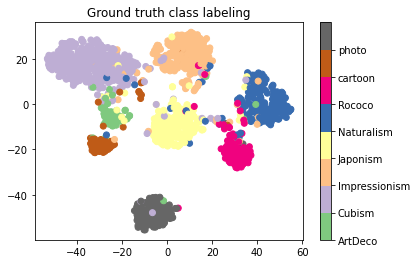

In [83]:
plt.scatter(x=tfidf_embed[:,0], y=tfidf_embed[:,1], c=y_full, cmap="Accent")
plt.title('Ground truth class labeling')

cb = plt.colorbar()
loc = np.arange(0, max(y_full), max(y_full) / num_classes)
cb.set_ticks(loc)
cb.set_ticklabels(sorted(os.listdir(DATA_PATH)))
plt.show()

Рассмотрим полученное представление. В нашем случае объекты действительно образуют кластеры. Как мы видим из разметки, каждому такому кластеру соответсвует свой класс в исходной выборке. 

Такого удачного разбиения нам удалось добиться благодаря природе данных. Предпоследний слой нейронной сети преобразует признаковое пространство к такому виду, что классы в нём линейно разделимы. Именно поэтому проекция `t-SNE` получилась столь удачной.

Однако, как мы видим, некоторые кластеры зашумлены объектами из чужих классов. Это связано с тем, что алгоритм имеет не стопроцентную точность и может ошибаться. Повышение размерности признакового пространства помогло бы фактически увеличить расстояние между кластерами и улучшить результат классификации. Но, как уже упоминалось выше, этот прирост столь незначителен, что я решил сфокусироваться на борьбе с проклятием размерности.

Ниже приведены результаты кластеризации двух алгоритмов (K средних и иерархическая кластеризация), которые как раз хорошо выделяют выпуклые кластеры. Я решил использовать в обоих случаях евклидово расстояние, потому что именно оно обычно подразумевается в контексте линейной разделимости. Также мне показалось уместным выделить $8$ кластеров, по одному на каждый класс, ведь на основе этой информации строилось рассматриваемое признаковое пространство. 

Кроме того будем измерять коэффициент силуэта, чтобы иметь возможность сравнить используемые методы.

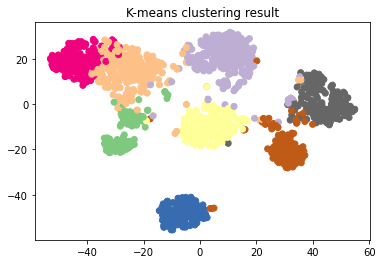

Silhouette score:  0.23486687


In [84]:
kmeans_alg = KMeans(n_clusters=num_classes).fit(X_full)
kmeans = kmeans_alg.predict(X_full)

plt.scatter(x=tfidf_embed[:,0], y=tfidf_embed[:,1], c=kmeans, cmap="Accent")
plt.title('K-means clustering result')
plt.show()
print('Silhouette score: ', silhouette_score(X_full, kmeans))

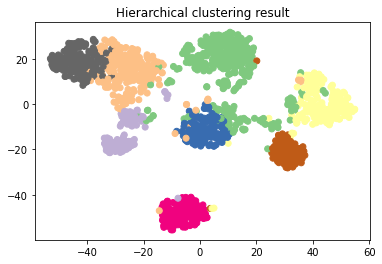

Silhouette score:  0.21116687


In [85]:
hierarchical = AgglomerativeClustering(n_clusters=num_classes).fit_predict(X_full)


plt.scatter(x=tfidf_embed[:,0], y=tfidf_embed[:,1], c=hierarchical, cmap="Accent")
plt.title('Hierarchical clustering result')
plt.show()
print('Silhouette score: ', silhouette_score(X_full, hierarchical))

Как мы видим, оба алгоритма неплохо справились с задачей кластеризации, их показатели практически идентичны. Однако они оба не смогли распознать один кластер. 

Это связано с дисбалансом классов в обучающей выборке. Стили `ArtDeco` и `cartoon` в некотором смысле похожи, а также одинаково мало представлены в выборке. Из-за этого почти всегда они попадают в один кластер, а доплнительное внимание притягивает на себя класс `Cubism`, который, наоборот, имеет в выборке слишком много объектов.

При попытке файнтьюнинга алгоритма, мы сталкиваемся со слиянием или разделением других кластеров, поскольку точность исходной сети всё же не идеальна, и кластеры могут наслаиваться друг на друга.

In [73]:
print('Number of instances for each class: ')
for class_num, class_name in enumerate(sorted(os.listdir(DATA_PATH))):
    sp = (13 - len(class_name)) * ' '
    print('    ' + class_name + sp + '\t', (y_full == class_num).sum())

Number of instances for each class: 
    ArtDeco      	 65
    Cubism       	 365
    Impressionism	 240
    Japonism     	 203
    Naturalism   	 218
    Rococo       	 117
    cartoon      	 75
    photo        	 139


Используя алгоритм `K-means`, изучим наиболее типичных представителей каждого кластрета, то есть координаты их центров. Поскольку размерность признакового пространства довольно высока, изобразим результаты с помощью `heatmap`.

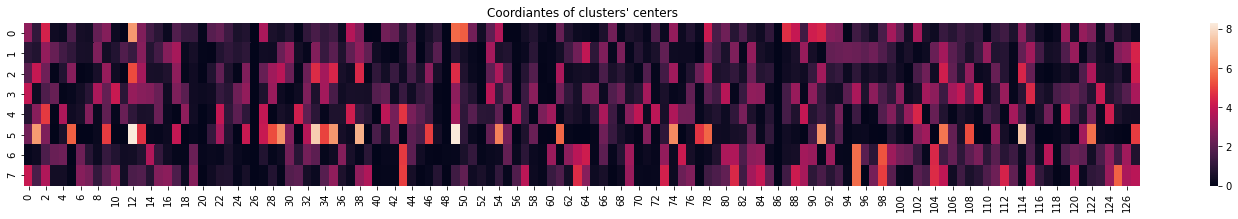

In [107]:
plt.figure(figsize=(25,3))
plt.title("Coordiantes of clusters' centers")
plt.xlabel('feature number')
plt.ylabel('cluster number')
sns.heatmap(kmeans_alg.cluster_centers_)
plt.show()

В признаковых описаниях довольно много нулевых значений, потому что мы работаем со слоем сети после применения функции `ReLu`. 

В целом, из этих данных довольно сложно выловить какую-либо полезную информацию. Можно сказать лишь, что классы `Rococo` и `Naturalism` (номера $6$ и $7$) довольно похожи, что в целом соответствует действительности.

## Градиентный бустинг на нейросетевых эмбедингах

Теперь попробуем обучить градиентный бустинг на полученном признаковом представлении изображений. Результат работы `XGBoost` сравним с качеством работы исходной нейронной сети.

In [87]:
xgb = xgboost.XGBClassifier(objective="multi:softprob", use_label_encoder=False)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print('Untuned XGBoost accuracy: ', round(accuracy_score(y_test, y_pred), 4))

Untuned XGBoost accuracy:  0.7676


In [101]:
print('VGG 13 accuracy: ', round(float(acc[-1].cpu().numpy()), 4))

VGG 13 accuracy:  0.7746


Не настроенный градиентный бустинг проигрывает по качеству нейронной сети, но перед формированием окончательных выводов стоит попробовать подобрать для него оптимальные гиперпараметры. 

При этом, чтобы избежать переобучения алгоритма, валидационную выборку стоит брать из теста, потому что обучающая выборка и так линейно разделима в рассматриваемом пространстве.

In [130]:
X_test_1, X_val, y_test_1, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print('Best XGBoost parameters: ')

n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
scores = []
for n in n_trees:
    xgb = xgboost.XGBClassifier(n_estimators=n, objective="multi:softprob", use_label_encoder=False)
    xgb.fit(X_train, y_train)
    scores.append(accuracy_score(y_val, xgb.predict(X_val)))

best_n_estimators = n_trees[np.argmax(scores)]
print('    n_estimators = ', best_n_estimators)

depth = list(range(1, 11, 3))
scores = []
for d in depth:
    xgb = xgboost.XGBClassifier(n_estimators=best_n_estimators, max_depth=d, objective="multi:softprob", use_label_encoder=False)
    xgb.fit(X_train, y_train)
    scores.append(accuracy_score(y_val, xgb.predict(X_val)))

best_max_depth = depth[np.argmax(scores)]
print('    max_depth = ', best_max_depth)

rate = np.logspace(-1, -3, 3)
scores = []
for l in rate:
    xgb = xgboost.XGBClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, learning_rate=l, 
                                                            objective="multi:softprob", use_label_encoder=False)
    xgb.fit(X_train, y_train)
    scores.append(accuracy_score(y_val, xgb.predict(X_val)))

best_learning_rate = rate[np.argmax(scores)]
print('   learning_rate = ', best_learning_rate)

Best XGBoost parameters: 
    n_estimators =  100
    max_depth =  4
   learning_rate =  0.1


In [131]:
xgb = xgboost.XGBClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, learning_rate=best_learning_rate, 
                                                          objective="multi:softprob", use_label_encoder=False)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test_1)

print('Tuned XGBoost accuracy: ', round(accuracy_score(y_test_1, y_pred), 4))

Tuned XGBoost accuracy:  0.784


На этот раз градиентный бустинг по точности превзошёл "голую" нейронную сеть.

Выход последнего слоя сети предполагает линейную разделимость данных, `XGBoost` же способен исправить минорные ошибки линейного классификатора и обойти его по качеству.

Таким образом, бустинг может дать прирост в точности при грамотном подборе параметров. Однако для боллее значительного увеличения показателей стоит всё же оптимизировать архитектуру сети.